In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import numpy as np
from scipy import stats

import matplotlib.pyplot as plt

In [3]:
rnaseq_file = '../Data/raw_data/41467_2019_13483_MOESM4_ESM.xlsx'

# Basic data processing

In [4]:
metadata_df = pd.read_excel(rnaseq_file, sheet_name='Metadata')
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'].isnull() == False]
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Growth Rate (1/hr)'] > 0.0]
print(metadata_df.shape)
metadata_df = metadata_df[metadata_df['Alignment'] > 80]
print(metadata_df.shape)

(278, 26)
(195, 26)
(179, 26)
(173, 26)


In [5]:
expression_df = pd.read_excel(rnaseq_file, sheet_name='Expression Data', index_col=0)
print(expression_df.shape)
expression_df = expression_df[metadata_df['Sample ID']]
print(expression_df.shape)
assert list(metadata_df['Sample ID']) == list(expression_df.columns)

(3923, 278)
(3923, 173)


# Dimensionality reduction techniques to assess associations with growth rate

What we're \*trying\* to do here is say that 4,xyz genes is simply too many to deal with. Can we condense these numbers into a more limited number of dimensions and then ask whether variation in any of those transformed dimensions are associated with growth rate?

"Limited" is arbitrary, so we can change the number of principal components to include/consider as well as the transformation kernel.

*Something else to consider is how and whether to standardize the values which can help with PCA in general.*

In [46]:
from sklearn.decomposition import PCA, KernelPCA
from scipy.stats import zscore

In [86]:
pca = PCA(n_components=10)
pca_transform = pca.fit_transform(expression_df.T.values)
print('PCA variance:\t\t', pca.explained_variance_ratio_)

explained_variance = np.var(expression_df.values.T, axis=0)
explained_variance_ratio = np.var(pca_transform, axis=0) / np.sum(explained_variance)
print('PCA variance by hand:\t', explained_variance_ratio)
print()
print('Total PCA variance:', np.sum(explained_variance_ratio))
print()
print('PCA shape:', pca_transform.shape)
print()
print('Correlations with growth rate (PCA index, correlation results):')
for i in range(pca_transform.shape[1]):
    print(i, stats.spearmanr(pca_transform[:,i], metadata_df['Growth Rate (1/hr)']))

PCA variance:		 [0.17868669 0.14011406 0.10637011 0.0797626  0.07526526 0.03916571
 0.02618565 0.02432209 0.02130139 0.01878229]
PCA variance by hand:	 [0.17868669 0.14011406 0.10637011 0.0797626  0.07526526 0.03916571
 0.02618565 0.02432209 0.02130139 0.01878229]

Total PCA variance: 0.7099558503558325

PCA shape: (173, 10)

Correlations with growth rate (PCA index, correlation results):
0 SpearmanrResult(correlation=-0.5117343892094286, pvalue=6.225942957627076e-13)
1 SpearmanrResult(correlation=0.42290201397067795, pvalue=6.7766152271492115e-09)
2 SpearmanrResult(correlation=0.1440604895186832, pvalue=0.05862980753303296)
3 SpearmanrResult(correlation=-0.2508107322809927, pvalue=0.0008736270685379527)
4 SpearmanrResult(correlation=0.2660693782156894, pvalue=0.0004028320340034326)
5 SpearmanrResult(correlation=-0.062950753436428, pvalue=0.4106207099696768)
6 SpearmanrResult(correlation=0.07572869570932637, pvalue=0.32204837211234844)
7 SpearmanrResult(correlation=-0.08615112871083497

In [88]:
kpca = KernelPCA(n_components=10, kernel='poly')
kpca_transform = kpca.fit_transform(expression_df.values.T)
explained_variance = np.var(expression_df.values.T, axis=0)
explained_variance_ratio = np.var(kpca_transform, axis=0) / np.sum(explained_variance)
print('kPCA variance by hand:\t', explained_variance_ratio)
print()
print('Total kPCA variance:', np.sum(explained_variance_ratio))
print()
print('kPCA shape:', kpca_transform.shape)
print()
print('Correlations with growth rate (kPCA index, correlation results):')
for i in range(kpca_transform.shape[1]):
    print(i, stats.spearmanr(kpca_transform[:,i], metadata_df['Growth Rate (1/hr)']))

kPCA variance by hand:	 [0.22137642 0.15666793 0.12812853 0.08702408 0.08588262 0.04405961
 0.03025579 0.02938363 0.0254857  0.02341422]

Total kPCA variance: 0.8316785388405309

kPCA shape: (173, 10)

Correlations with growth rate (kPCA index, correlation results):
0 SpearmanrResult(correlation=-0.5635074126578996, pvalue=6.95402396193613e-16)
1 SpearmanrResult(correlation=0.40019499724697244, pvalue=4.888958179680638e-08)
2 SpearmanrResult(correlation=0.14161787558415245, pvalue=0.06308854802402486)
3 SpearmanrResult(correlation=-0.11693258434123675, pvalue=0.1254930844860409)
4 SpearmanrResult(correlation=0.3182866622418923, pvalue=1.9760985790149936e-05)
5 SpearmanrResult(correlation=-0.08651038272681646, pvalue=0.2577435327041751)
6 SpearmanrResult(correlation=0.058127224422858205, pvalue=0.44746726215372623)
7 SpearmanrResult(correlation=-0.1619967166290202, pvalue=0.03322343198648699)
8 SpearmanrResult(correlation=0.036547445987633084, pvalue=0.6330906819709623)
9 SpearmanrResul

**And just for fun, trying dimensionality reduction with a neural network based autoencoder**

But I'm still not sure how to preserve variance and thus quantify the success of an autoencoder

In [89]:
import tensorflow as tf
assert tf.__version__ >= "2.0"
print(tf.__version__)
tf.config.threading.set_intra_op_parallelism_threads(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.random.set_seed(42)

from tensorflow import keras
print(keras.__version__)

from tensorflow.keras import layers

from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

2.2.0
2.3.0-tf


In [114]:
X_all = expression_df.values.T
X_train, X_val = train_test_split(X_all, train_size = 0.8, random_state = 42)

print(X_all.shape, X_train.shape, X_val.shape)

# X_train = minmax_scale(X_train, axis = 0)
# X_val = minmax_scale(X_val, axis = 0)
print(X_all.shape, X_train.shape, X_val.shape)

(173, 3923) (138, 3923) (35, 3923)
(173, 3923) (138, 3923) (35, 3923)


In [129]:
# reduce to xyz features
encoding_dim = 10

input_df = layers.Input(shape=(X_all.shape[1],))
encoded = layers.Dense(encoding_dim, activation='elu')(input_df)
# encoded = layers.Dense(encoding_dim, activation='linear')(encoded)
# encoded = layers.Dense(encoding_dim*2, activation='elu')(encoded)
# encoded = layers.BatchNormalization()(encoded)
encoded = layers.Dropout(0.5)(encoded)
decoded = layers.Dense(X_all.shape[1], activation='sigmoid')(encoded)

# encoder
autoencoder = keras.Model(input_df, decoded)

# intermediate result
encoder = keras.Model(input_df, encoded)

autoencoder.compile(optimizer='sgd', loss='mean_squared_error')

autoencoder.fit(X_train, X_train,
                epochs=10,
                batch_size=32,
                validation_data=(X_val, X_val),
                verbose=0);

In [130]:
encoded_X_all = encoder.predict(X_all)
print(encoded_X_all.shape)
for i in range(encoding_dim):
    print(i, stats.spearmanr(encoded_X_all[:,i], metadata_df['Growth Rate (1/hr)']))

(173, 10)
0 SpearmanrResult(correlation=-0.4512910012031265, pvalue=4.621554132604088e-10)
1 SpearmanrResult(correlation=-0.4436773275345793, pvalue=9.731263713955468e-10)
2 SpearmanrResult(correlation=0.015772174776835273, pvalue=0.8368225834740041)
3 SpearmanrResult(correlation=0.1544121846745052, pvalue=0.04251601180115212)
4 SpearmanrResult(correlation=-0.2587246406450567, pvalue=0.0005881258799288646)
5 SpearmanrResult(correlation=-0.5152815636043364, pvalue=4.051435625928383e-13)
6 SpearmanrResult(correlation=-0.4246106855582904, pvalue=5.805249083969e-09)
7 SpearmanrResult(correlation=0.0021653992711398126, pvalue=0.9774428712790408)
8 SpearmanrResult(correlation=-0.2475046730083531, pvalue=0.0010269118436698496)
9 SpearmanrResult(correlation=-0.37757584860620375, pvalue=3.0380133222915266e-07)


# Assess individual gene correlations with growth rate
 
How about clustering genes together?

Also there are some slight statistical issues here with treating replicates as independent experiments (they shouldn't be)

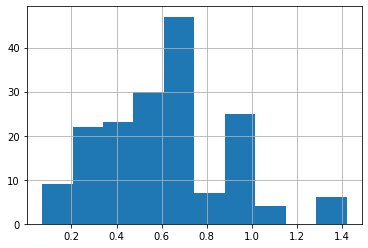

In [146]:
metadata_df['Growth Rate (1/hr)'].hist()

In [147]:
tempy = []
for index in expression_df.index:
    rho, p = stats.spearmanr(expression_df.loc[index], metadata_df['Growth Rate (1/hr)'])
    tempy.append((index, rho, p))
tempy.sort(key=lambda x: x[1])

Text(0, 0.5, "Spearman's rho correlation\n(expression vs growth)")

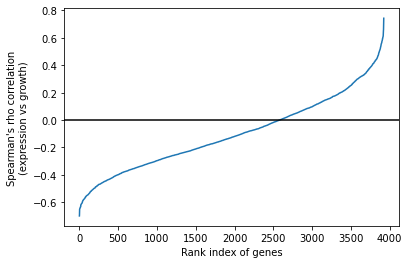

In [148]:
fig, ax = plt.subplots()
ax.plot([i[1] for i in tempy])
ax.axhline(0, c='k')
ax.set_xlabel('Rank index of genes')
ax.set_ylabel('Spearman\'s rho correlation\n(expression vs growth)')

**How about total reads?**

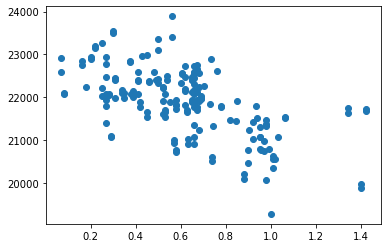

In [149]:
a = metadata_df['Growth Rate (1/hr)']
b = expression_df.sum()

fig, ax = plt.subplots()
ax.scatter(a,b)

# Incorporating external data sources

In [152]:
other_df = pd.read_csv('../Data/ecoli_info/temp_ecoli_master_table.tsv', sep='\t', index_col=0)
print(other_df.shape)
other_df = other_df[other_df['CAI'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['roc_semppr_mean'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['iCUB'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['tAI'].isnull()==False]
print(other_df.shape)
other_df = other_df[other_df['stAIcalc'].isnull()==False]
print(other_df.shape)

(4355, 13)
(4310, 13)
(4310, 13)
(4310, 13)
(4310, 13)
(4310, 13)


In [153]:
other_df

,gene,start_loc,stop_loc,strand,cds_seq,us_seq,well_behaved,GC_percent_cds,roc_semppr_mean,iCUB,CAI,tAI,stAIcalc
locus_tag,,,,,,,,,,,,,
b0001,thrL,189,255,+,ATGAAACGCATTAGCACCACCATTACCACCACCATCACCATTACCA...,CAGATAAAAATTACAGAGTACACAACATCC,True,0.515152,1.244106,32.046035,0.617266,0.262286,0.258417
b0002,thrA,336,2799,+,ATGCGAGTGTTGAAGTTCGGCGGTACATCAGTGGCAAATGCAGAAC...,TTTTCGACCAAAGGTAACGAGGTAACAACC,True,0.530654,1.034078,55.949262,0.353246,0.230564,0.216862
b0003,thrB,2800,3733,+,ATGGTTAAAGTTTATGCCCCGGCTTCCAGTGCCAATATGAGCGTCG...,GTACCCTCTCATGGAAGTTAGGAGTCTGAC,True,0.562701,0.994168,56.062386,0.357812,0.216292,0.210420
b0004,thrC,3733,5020,+,ATGAAACTCTACAATCTGAAAGATCACAACGAGCAGGTCAGCTTTG...,ACGGCGGGCGCACGAGTACTGGAAAACTAA,True,0.528361,1.176750,53.052776,0.394675,0.231407,0.209784
b0005,yaaX,5233,5530,+,GTGAAAAAGATGCAATCTATCGTACTCGCACTTTCCCTGGTTCTGG...,CATAACGGGCAATGATAAAAGGAGTAACCT,True,0.538721,0.837528,50.705530,0.374371,0.197715,0.208944
...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,creC,4636695,4638120,+,ATGCGTATCGGCATGCGGTTGTTGCTGGGCTATTTTTTACTGGTGG...,CGGCATGGGATATAGCCTGAGGGGCCTGTA,True,0.538947,0.829794,55.967103,0.293537,0.212672,0.206721
b4400,creD,4638177,4639530,+,ATGTTGAAATCCCCCCTGTTCTGGAAAATGACTAGCCTGTTTGGTG...,TATCCTGCTGCCATTGCAAAGGAGAAGACT,True,0.495935,0.739848,54.634345,0.288635,0.210078,0.199677
b4401,arcA,4639589,4640306,-,ATGCAGACCCCGCACATTCTTATCGTTGAAGACGAGTTGGTAACAC...,TCGATTTAGTTGGCAATTTAGGTAGCAAAC,True,0.510460,1.676448,48.981781,0.530773,0.275348,0.239921


In [154]:
print(expression_df.shape)
expression_df = expression_df[expression_df.index.isin(other_df.index)]
print(expression_df.shape)
other_df = other_df[other_df.index.isin(expression_df.index)]
print(other_df.shape)

(3923, 173)
(3859, 173)
(3859, 13)


In [155]:
expression_df = expression_df.sort_index()
other_df = other_df.sort_index()

## What metric correlates best with expression data?

In [173]:
metrics = ['GC_percent_cds', 'roc_semppr_mean', 'iCUB', 'CAI', 'tAI', 'stAIcalc']

for metric in metrics[:]:
    print(metric)
    tempy = []
    for column in expression_df.columns:
        tempy.append(stats.spearmanr(other_df[metric], expression_df[column])[0])
    print('Mean:', np.mean(tempy))
    print('Median:', np.median(tempy))
    print('Max:', np.max(np.abs(tempy)))
    print()

GC_percent_cds
Mean: 0.05470493491676735
Median: 0.04842152926979853
Max: 0.1808102950864034

roc_semppr_mean
Mean: 0.3957754416125814
Median: 0.3948306456620813
Max: 0.484170412507893

iCUB
Mean: -0.29614608151881755
Median: -0.2887424886286724
Max: 0.38153718617504284

CAI
Mean: 0.41321347461508845
Median: 0.41185137712741005
Max: 0.4772136685595271

tAI
Mean: 0.37615000279184263
Median: 0.37625149919776335
Max: 0.4325669145885162

stAIcalc
Mean: 0.33404045122335485
Median: 0.33485180228550554
Max: 0.3716422880846404



## How do metric *correlations* with expression in individual conditions correlate with growth rate?

In [187]:
metric = 'GC_percent_cds'
# metric = 'roc_semppr_mean'
# metric = 'iCUB'
# metric = 'CAI'
# metric = 'tAI'
# metric = 'stAIcalc'



tempy = []
listy_a = []
listy_b = []
for column in expression_df.columns:
    rho, p = stats.spearmanr(other_df[metric], expression_df[column])
    listy_a.append(rho)
    listy_b.append(metadata_df[metadata_df['Sample ID']==column].iloc[0]['Growth Rate (1/hr)'])
    tempy.append((column, rho, p))
tempy.sort(key=lambda x: x[1])

SpearmanrResult(correlation=0.28979487440542095, pvalue=0.0001100273726425804)


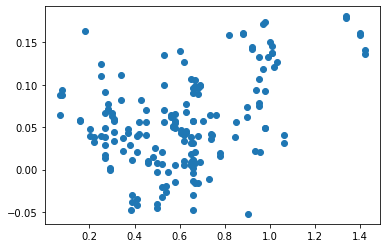

In [188]:
fig, ax = plt.subplots()
ax.scatter(listy_b, listy_a)
print(stats.spearmanr(listy_b, listy_a))

## Example correlations between metric and average expression

SpearmanrResult(correlation=0.4614061108752819, pvalue=8.763095745222825e-203)


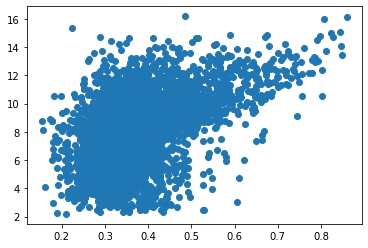

In [200]:
# metric = 'GC_percent_cds'
# metric = 'roc_semppr_mean'
# metric = 'iCUB'
metric = 'CAI'
# metric = 'tAI'
# metric = 'stAIcalc'

fig, ax = plt.subplots()
ax.scatter(other_df[metric], expression_df.max(axis=1))
print(stats.spearmanr(other_df[metric], expression_df.max(axis=1)))

# Quantify each individual gene's correlation with growth rate and assess its relationship/correlation with the codon metrics

In [203]:
import statsmodels.formula.api as smf

In [211]:
###Get correlation between expression and growth for each gene
listy = []
for index in expression_df.index:
    rho, p = stats.spearmanr(expression_df.loc[index], metadata_df['Growth Rate (1/hr)'])
    listy.append(rho)

In [214]:
# metric = 'GC_percent_cds'
# metric = 'roc_semppr_mean'
# metric = 'iCUB'
metric = 'CAI'
# metric = 'tAI'
# metric = 'stAIcalc'

# plot_df = pd.DataFrame(zip(other_df[metric], expression_df.mean(axis=1), listy))
# plot_df = pd.DataFrame(zip(other_df[metric], expression_df.median(axis=1), listy))
plot_df = pd.DataFrame(zip(other_df[metric], expression_df.max(axis=1), listy))

plot_df.columns = ['codon_metric', 'expression_summary', 'growth_summary']

fitted_model = smf.ols('codon_metric ~ expression_summary * growth_summary', data=plot_df).fit()
print(fitted_model.pvalues)
print(fitted_model.summary())

Intercept                            1.201398e-287
expression_summary                   2.085459e-248
growth_summary                        5.563325e-17
expression_summary:growth_summary     4.129076e-49
dtype: float64
                            OLS Regression Results                            
Dep. Variable:           codon_metric   R-squared:                       0.370
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     753.9
Date:                Wed, 06 Jan 2021   Prob (F-statistic):               0.00
Time:                        20:47:08   Log-Likelihood:                 4326.7
No. Observations:                3859   AIC:                            -8645.
Df Residuals:                    3855   BIC:                            -8620.
Df Model:                           3                                         
Covariance Type:            nonrobust                                 